Here we will test parameter recovery and model comparison for several models applied to the temporal reversal learning task.

In [1]:
import torch
torch.set_default_dtype(torch.float64)
from torch import ones, zeros, tensor
torch.manual_seed(1234)

import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

Lets start by simulating behavioral data for the temporal reversal learning.

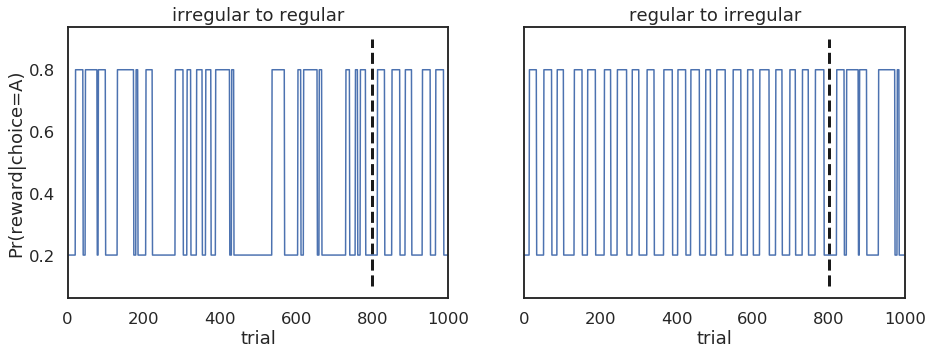

In [2]:
# load stimuli (trial offers, advices, and reliability of advices)
data = io.loadmat('pilot/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

# plot temporal structure of reversal in two conditions
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax[0].plot(.6*Sirr + .2, lw=1.5);
ax[1].plot(.6*Sreg + .2, lw=1.5);
ax[0].vlines(800, .1, .9, 'k', linestyle='--', lw = 3)
ax[1].vlines(800, .1, .9, 'k', linestyle='--', lw = 3)
ax[0].set_xlabel('trial')
ax[0].set_ylabel('Pr(reward|choice=A)')
ax[1].set_xlabel('trial')
ax[0].set_title('irregular to regular')
ax[1].set_title('regular to irregular')
ax[0].set_xlim([1, 1000]);

fig.savefig('reversal_schedule.svg', dpi=600)

Sirr = torch.from_numpy(Sirr)
Oirr = torch.from_numpy(Oirr)
Sreg = torch.from_numpy(Sreg)
Oreg = torch.from_numpy(Oreg)

In [3]:
blocks = 1 # number of blocks
nsub = 26  # number of subjects
trials = 1000  # number of samples

from befit.tasks import TempRevLearn
from befit.simulate import Simulator
from befit.agents import RLTempRevLearn, BayesTempRevLearn

rewards = zeros(blocks, trials, nsub, 2)
rewards[..., :nsub//2, :] = Oreg.reshape(1, trials, 1, 2).repeat(1, 1, nsub//2, 1)
rewards[..., nsub//2:, :] = Oirr.reshape(1, trials, 1, 2).repeat(1, 1, nsub//2, 1)
rewards = ((rewards + 1)/2).long()

offers = zeros(blocks, trials, nsub, dtype=torch.long)

states = zeros(blocks, trials, nsub)
states[..., :nsub//2] = Sreg.reshape(1, trials, 1).repeat(1, 1, nsub//2)
states[..., nsub//2:] = Sirr.reshape(1, trials, 1).repeat(1, 1, nsub//2)
states = states.long()

stimuli = {'states': states, 
           'rewards': rewards, 
           'offers': offers}

temprev = TempRevLearn(stimuli, nsub=nsub)

# rl agent
rl_agent = RLTempRevLearn(runs=nsub, trials=trials)
trans_pars1 = tensor([[0.6, -1.9, .8, -1.6]]) + torch.randn(nsub, 4)*torch.tensor([.08, .15, .09, 0.2])
rl_agent.set_parameters(trans_pars1)

sim1 = Simulator(temprev, rl_agent, runs=nsub, trials=trials)
sim1.simulate_experiment()

# bayes agent
edhmm_agent = BayesTempRevLearn(runs=nsub, trials=trials)
trans_pars2 = torch.stack([tensor([[-1., 2.9, 2., 0., 0., 0.]]) + torch.randn(nsub//2, 6)*torch.tensor([.1, .1, .1, .1, .1, .1]), 
                           tensor([[2., 2.9, 2., 0., 0., 0.]]) + torch.randn(nsub//2, 6)*torch.tensor([.1, .1, .1, .1, .1, .1])],
                         dim=0).reshape(-1, 6)
edhmm_agent.set_parameters(trans_pars2)

sim2 = Simulator(temprev, edhmm_agent, runs=nsub, trials=trials)
sim2.simulate_experiment()

## Plot behaviour

In [4]:
def plotting(responses, states):
    sns.set_palette('Set2', 8)
    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    fig1.tight_layout()
    fig2.tight_layout()

    mc_per_trial = {}
    mh_per_trial = {}
    for i in range(2):
        C = np.array([]).reshape(0, trials)
        A = np.array([]).reshape(0, trials)
        correct = {}
        hints = {}
    
        p1 = i*nsub//2
        p2 = (i+1)*nsub//2
        A = responses[0, :, p1:p2].transpose(dim0=1, dim1=0) == 2
        C = (states == responses)[0, :, p1:p2].transpose(dim0=1, dim1=0).float()
        C[A] = np.nan
        C = C.numpy()
        A = A.numpy()
        
        reversal = np.vstack([np.zeros((1,nsub)),np.abs(np.diff(states[0], axis=0))])[:, -i].astype(np.long)
        
        count = 0
        for t in range(trials):
            if reversal[t] == 1:
                correct[count] = np.nan_to_num(C[:,t-10:t+10]).sum(axis = 0)
                hints[count] = np.nan_to_num(A[:,t-10:t+10]).sum(axis = 0)
                count += 1

        phase_rev_count = reversal.reshape(-1, 200).sum(axis=-1)
        count = 0
        for block, prv in enumerate(phase_rev_count):
            phase_correct  = np.zeros(20)
            phase_hints = np.zeros(20)
            for _ in range(prv):
                phase_correct += correct[count]
                phase_hints += hints[count]
                count += 1
        
            phase_correct /= (nsub*prv/2)
            phase_hints /= (nsub*prv/2)
            ax1[i].plot(np.arange(-10, 10), phase_correct, label = block+1)
            ax2[i].plot(np.arange(-10, 10), phase_hints, label = block+1)
    
        mc_per_trial[i] = np.nanmean(C.reshape(nsub//2, -1, 200), axis=-1)
        mh_per_trial[i] = np.nanmean(A.reshape(nsub//2, -1, 200), axis=-1)

    mc_pt = pd.DataFrame()
    mh_pt = pd.DataFrame()
    order = ['reg', 'irr']
    for i in range(2):
        df1 = pd.DataFrame(mc_per_trial[i], columns = [1,2,3,4,5])
        df1['order'] = order[i]
        df2 = pd.DataFrame(mh_per_trial[i], columns = [1,2,3,4,5])
        df2['order'] = order[i]
        mc_pt = mc_pt.append(df1, ignore_index = True)
        mh_pt = mh_pt.append(df2, ignore_index = True)

    mc_pt = mc_pt.melt(id_vars = ['order'], value_vars = [1,2,3,4,5])
    mh_pt = mh_pt.melt(id_vars = ['order'], value_vars = [1,2,3,4,5])

    ax1[0].legend(title='block')
    ax1[0].set_xlim([-10,9])
    ax1[0].set_ylabel('performance')
    ax1[0].set_xlabel('relative trial number')
    ax1[1].set_xlabel('relative trial number')
    ax1[0].set_title('regular->irregular')
    ax1[1].set_title('irregular->regular')
    ax1[0].vlines(0, .1, .9, color = 'k', linestyle = '--')
    ax1[1].vlines(0, .1, .9, color = 'k', linestyle = '--')

    ax2[0].legend(title='block')
    ax2[0].set_xlim([-10,9])
    ax2[0].set_ylabel('exploration prob.')
    ax2[0].set_xlabel('relative trial number')
    ax2[1].set_xlabel('relative trial number')
    ax2[0].set_title('regular->irregular')
    ax2[1].set_title('irregular->regular')
    ax2[0].vlines(0, .0, .2, color = 'k', linestyle = '--')
    ax2[1].vlines(0, .0, .2, color = 'k', linestyle = '--')


    fig3, ax3 = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=False)
    fig3.tight_layout()
    fig3.subplots_adjust(wspace=.25)
    sns.boxplot(x='variable', y='value', data=mc_pt, hue='order', ax=ax3[0])

    ax3[0].vlines(3.5, .4, .9, color = 'k', linestyle = '--')
    ax3[0].set_xlabel('block')
    ax3[0].set_ylabel('performance')

    sns.boxplot(x='variable', y='value', data=mh_pt, hue='order', ax=ax3[1])

    ax3[1].vlines(3.5, .0, .2, color = 'k', linestyle = '--')
    ax3[1].set_xlabel('block')
    ax3[1].set_ylabel('exploration prob.');
    
    return (fig1, fig2, fig3)

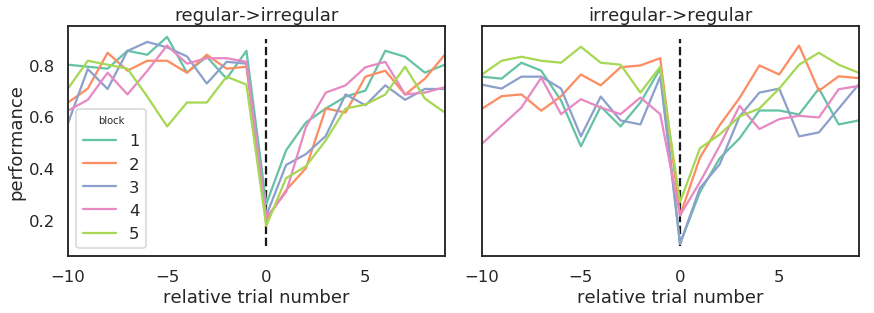

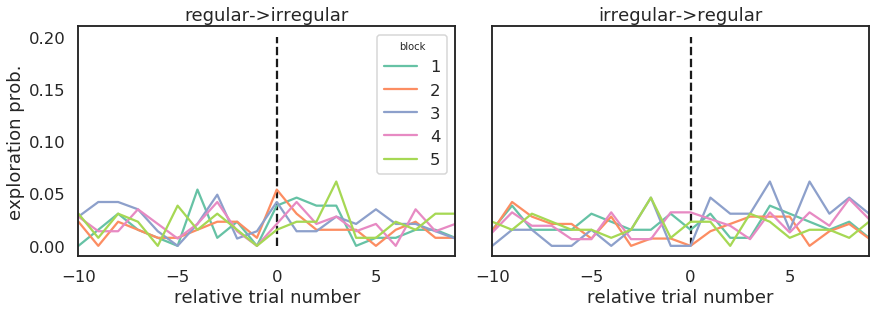

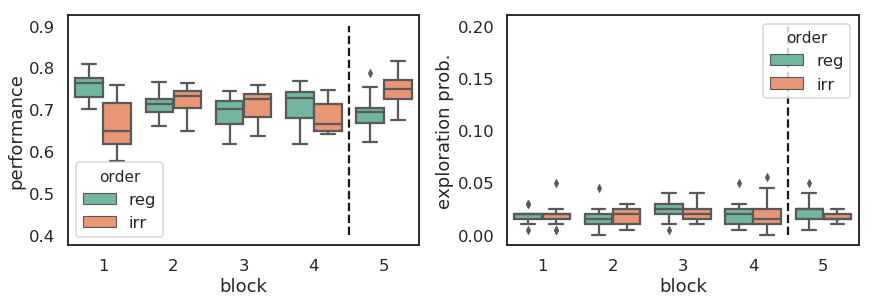

In [5]:
# plot behavior of the RL agent
figs = plotting(sim1.responses, states)

figs[0].savefig('rw_performance.svg', dpi=600)
figs[1].savefig('rw_hints.svg', dpi=600)
figs[2].savefig('rw_dist.svg', dpi=600)

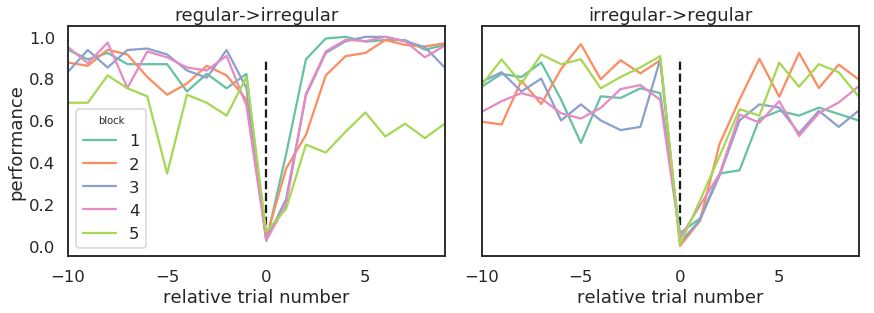

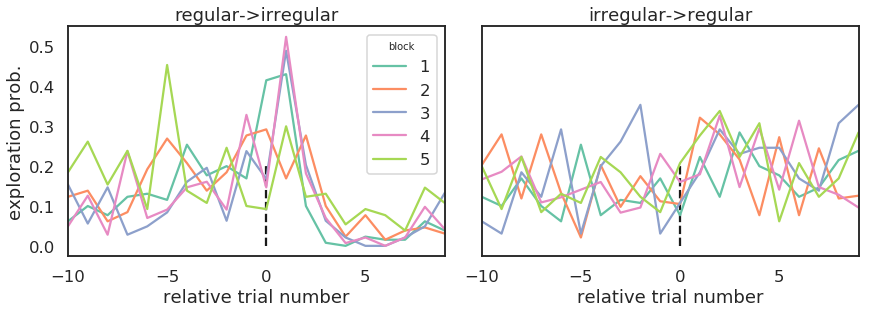

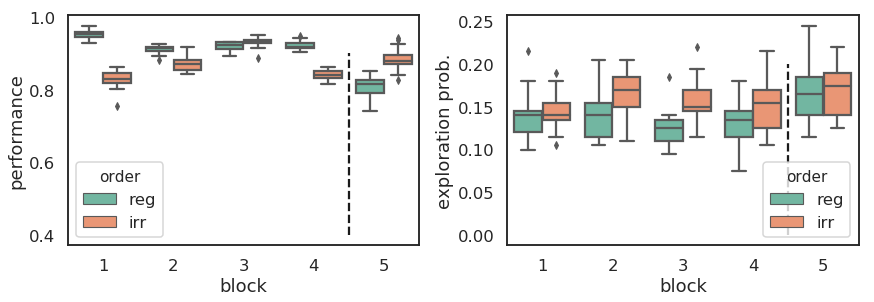

In [6]:
# plot behavior of the EDHMM agent
figs = plotting(sim2.responses, states)

figs[0].savefig('edhmm_performance.svg', dpi=600)
figs[1].savefig('edhmm_hints.svg', dpi=600)
figs[2].savefig('edhmm_dist.svg', dpi=600)

## Fit simulated behaviour

In [7]:
from befit.inference import Horseshoe

fit RL agent to simulated data

In [31]:
T1 = 0
T2 = 200

offers1 = sim1.stimulus['offers'][:, T1:T2]
outcomes1 = sim1.stimulus['outcomes'][:, T1:T2]
mask1 = torch.ones_like(offers1, dtype=torch.uint8)

stimulus = {'offers': offers1,
           'outcomes': outcomes1,
           'mask': mask1.double()}
mask = mask1.clone()
mask[:, :50] = 0

responses = sim1.responses[:, T1:T2]
rl_agent = RLTempRevLearn(runs=nsub, trials=T2-T1)
rl_agent.set_parameters()

rl_infer = Horseshoe(rl_agent, stimulus, responses, mask=mask)
rl_infer.infer_posterior(iter_steps=200)

labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
tp_df = rl_infer.sample_posterior(labels, n_samples=1000)

Mean ELBO 3361.00: 100%|██████████| 400/400 [1:03:40<00:00,  9.69s/it]


Compute fit quality and plot posterior estimates from a hierarchical parameteric model

In [32]:
labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'$\theta$']
trans_pars_rl = tp_df[0].melt(id_vars='subject', var_name='parameter')

#vals = [trans_pars1[:,0].numpy(), trans_pars1[:, 1].numpy(), trans_pars1[:, 2].numpy(), trans_pars1[:, 3].numpy()]
#posterior_accuracy(labels, trans_pars_rl, vals)

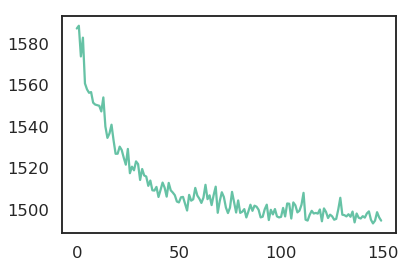

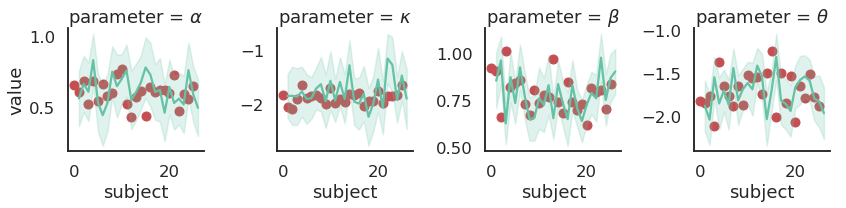

In [24]:
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.figure()    
plt.plot(rl_infer.loss[-150:])

g = sns.FacetGrid(trans_pars_rl, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

labels = [r'$\alpha$', r'$\kappa$', r'$\beta$', r'bias']
for i in range(len(labels)):
    g.axes[0,i].plot(np.arange(nsub), trans_pars1[:,i].numpy(),'ro', zorder = 0);

fit ED-HMM agent to simulated data

In [9]:
T1 = 0
T2 = 200

offers2 = sim2.stimulus['offers'][:, T1:T2]
outcomes2 = sim2.stimulus['outcomes'][:, T1:T2]
mask2 = torch.ones_like(offers2, dtype=torch.uint8)

stimulus = {'offers': offers2,
           'outcomes': outcomes2,
           'mask': mask2.double()}
mask = mask2.clone()
mask[:, :50] = 0

responses = sim2.responses[:, T1:T2]
edhmm_agent = BayesTempRevLearn(runs=nsub, trials=T2-T1)
edhmm_agent.set_parameters()

edhmm_infer = Horseshoe(edhmm_agent, stimulus, responses, mask=mask)
edhmm_infer.infer_posterior(iter_steps=5)


Mean ELBO 4833.31: 100%|██████████| 5/5 [02:16<00:00, 27.53s/it]


AssertionError: 

In [9]:
labels = [r'$\delta$', r'$\rho$', r'$\beta$', r'$\lambda$']
edhmm_tp_df = edhmm_infer.sample_posterior(labels, n_samples=1000)

trans_pars_edhmm = edhmm_tp_df[0].melt(id_vars='subject', var_name='parameter')

#vals = [trans_pars2[:, i].numpy() for i in range(len(labels))]
#posterior_accuracy(labels, trans_pars_hgf, vals)

Plot posterior estimates from simulated data for the HGF agent

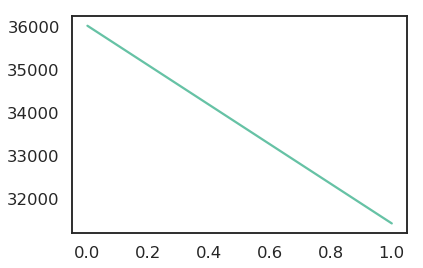

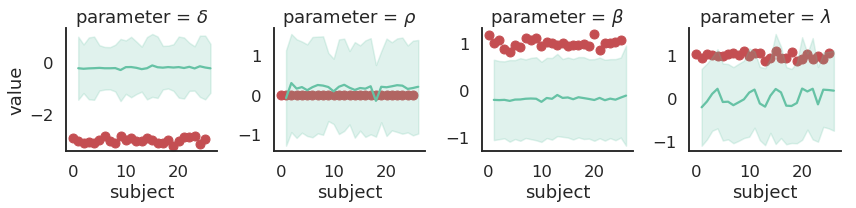

In [11]:
plt.figure()    
#plot convergence of stochasitc ELBO estimates (log-model evidence)
plt.plot(edhmm_infer.loss[-400:])

g = sns.FacetGrid(trans_pars_edhmm, col="parameter", height=3, sharey=False);
g = (g.map(sns.lineplot, 'subject', 'value', ci='sd'));

for i in range(len(labels)):
    g.axes[0,i].plot(np.arange(nsub), trans_pars2[:,i].numpy(),'ro', zorder = 0);

## Validate model comparison

In [32]:
rl_infer = [Horseshoe(rl_agent, stimuli, sim1.responses, mask=mask),
            Horseshoe(rl_agent, stimuli, sim2.responses, mask=mask),
            Horseshoe(rl_agent, stimuli, sim3.responses, mask=mask)]
evidences = torch.zeros(3, 3, 2*nsub)
for i in range(3):
    rl_infer[i].infer_posterior(iter_steps = 500)
    evidences[0, i] = rl_infer[i].get_log_evidence_per_subject()
    
hgf_infer = [Horseshoe(hgf_agent, stimuli, sim1.responses, mask=mask),
             Horseshoe(hgf_agent, stimuli, sim2.responses, mask=mask),
             Horseshoe(hgf_agent, stimuli, sim3.responses, mask=mask)]

for i in range(3):
    hgf_infer[i].infer_posterior(iter_steps = 500)
    evidences[1, i] = hgf_infer[i].get_log_evidence_per_subject()
    
sgf_infer = [Horseshoe(sgf_agent, stimuli, sim1.responses, mask=mask),
             Horseshoe(sgf_agent, stimuli, sim2.responses, mask=mask),
             Horseshoe(sgf_agent, stimuli, sim3.responses, mask=mask)]

for i in range(3):
    sgf_infer[i].infer_posterior(iter_steps = 500)
    evidences[2, i] = sgf_infer[i].get_log_evidence_per_subject()

Mean ELBO 7031.86: 100%|██████████| 500/500 [27:19<00:00,  3.13s/it]


In [33]:
print((evidences[:, 0].argmax(dim=0) == 0).sum().float()/(2*nsub))
print((evidences[:, 1].argmax(dim=0) == 1).sum().float()/(2*nsub))
print((evidences[:, 2].argmax(dim=0) == 2).sum().float()/(2*nsub))
evidences.sum(-1)

tensor(0.5700)
tensor(0.2100)
tensor(0.3900)


tensor([[-6794.9014, -7995.5371, -7023.8271],
        [-6820.9146, -8008.9907, -7034.6108],
        [-6827.4282, -8013.0645, -7025.3999]])

The diagonal elements in the above matrix are the lowest values for the corresponding column, which shows that we can accuretly infer the correct model over population. The question is what would be results per subject.